# Cargo Theft Dataset Pre-Processing

In [ ]:
# Import the necessary dependencies
import pandas as pd
import numpy as np

### Preprocessing the Data 

In [ ]:
# Read the CSV file into a DataFrame.
theft_df = pd.read_csv("Resources/CT_2013_2021.csv")
theft_df.head()

In [ ]:
# Data information
theft_df.info()

In [ ]:
# How many different values are each column
theft_df.nunique()

In [ ]:
# Null Values 
theft_df.isna().sum()

In [ ]:
# Duplicated Values
theft_df.duplicated().sum()

In [ ]:
dropped = ["ori", "data_year.1", "prop_desc_code.1", "state_abbr"]

In [ ]:
# Transformation and remove duplicate entries
theft_original_df = theft_df.drop(columns = ["ori", "data_year.1", "prop_desc_code.1", "state_abbr"], axis = 1).drop_duplicates()
print(theft_original_df.shape)
theft_original_df.head() 

In [ ]:
# Write this DataFrame out to a CSV file
theft_original_df.to_csv("Resources/cargo_theft_original.csv", index=False)

### Null Values in Dataset 

In [ ]:
#'public_agency_unit' column
theft_original_df.pub_agency_unit.value_counts()

In [ ]:
#'population_group_code' column
theft_original_df.population_group_code.value_counts()

In [ ]:
#'population_group_desc' column
theft_original_df.population_group_desc.value_counts()

In [ ]:
#'offender_race' column
theft_original_df.offender_race.value_counts()

In [ ]:
#'offender_ethnicity' column
theft_original_df.offender_ethnicity.value_counts()

In [ ]:
#'offender_age' column
theft_original_df.offender_age.value_counts().sort_index()

In [ ]:
#'offender_sex' column
theft_original_df.offender_sex.value_counts()

In [ ]:
#'weapon_code' column
theft_original_df.weapon_code.value_counts()

In [ ]:
#'weapon_name' column
theft_original_df.weapon_name.value_counts()

In [ ]:
#'stolen_value' column
theft_original_df.stolen_value.value_counts().sort_index()

In [ ]:
#'date_recoverd' column
theft_original_df.date_recovered.value_counts()

In [ ]:
# DataFrame in general
theft_original_df.agency_type_name.value_counts()

In [ ]:
# Offenses types
theft_original_df.offense_name.value_counts()

In [ ]:
# Offenses codes
theft_original_df.offense_code.value_counts()

In [ ]:
# Replace empty values
# Fixing categorical values
theft_original_df['offender_race'].fillna('Unknown', inplace = True)
theft_original_df['offender_ethnicity'].fillna('Unknown', inplace = True)
theft_original_df['offender_age'].fillna(0.0, inplace = True)
theft_original_df['offender_sex'].fillna('U', inplace = True)
theft_original_df['stolen_value'].fillna(0, inplace = True)
theft_original_df.weapon_code = theft_original_df.weapon_code.fillna("95")
theft_original_df.weapon_name = theft_original_df.weapon_name.fillna("Unknown")
theft_original_df.population_group_desc = theft_original_df.population_group_desc.fillna("National")
theft_original_df.population_group_code = theft_original_df.population_group_code.fillna("0")

In [ ]:
# Not necessary columns
not_added = ["Destruction/Damage/Vandalism of Property", "Drug/Narcotic Violations", "Impersonation", "Weapon Law Violations", "Drug Equipment Violations",
            "Simple Assault", "Aggravated Assault", "Kidnapping/Abduction", "Intimidation","Extortion/Blackmail", "Rape", "Murder and Nonnegligent Manslaughter",
            "Arson", "Hacking/Computer Invasion", "Fondling", "Pornography/Obscene Material","Human Trafficking, Involuntary Servitude", "Sodomy",
            "Animal Cruelty", "Bribery", "Sexual Assault With An Object"]

cleaned_data = theft_original_df.loc[~theft_original_df.offense_name.isin(not_added)]
print(cleaned_data.shape)
cleaned_data.head() 

In [ ]:
# Check the results.
cleaned_data.offense_code.value_counts()

In [ ]:
cleaned_data.describe()['stolen_value']

In [ ]:
# Write this DataFrame out to a CSV file
cleaned_data.to_csv("Resources/cargo_theft_cleaned.csv", index = False)

In [ ]:
# Determine which columns will be used as features and which column will be the target.
# For this case, it is easier to drop unneeded columns.
not_added = ["data_year", "pub_agency_unit", "population_group_desc", "offense_name", "victim_type_name", "location_name", "weapon_name", "prop_desc_name", "recovered_value", "date_recovered"]
binary_data = cleaned_data.drop(columns = not_added, axis = 1)
print(binary_data.shape)
binary_data.head() 

In [ ]:
# Write this DataFrame out to a CSV file
binary_data.to_csv("Resources/binary_classifier.csv", index = False)

## Logistic Regression

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import patsy
import itertools

In [ ]:
# Transform text/object into numerical data for features to be used. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

binary_data['population_group_code'] = le.fit_transform(cleaned_data['population_group_code'])
binary_data['offense_code'] = le.fit_transform(cleaned_data['offense_code'])
binary_data['offender_race'] = le.fit_transform(cleaned_data['offender_race'])
binary_data['offender_ethnicity'] = le.fit_transform(cleaned_data['offender_ethnicity'])
binary_data['offender_sex'] = le.fit_transform(cleaned_data['offender_sex'])
binary_data['victim_type_code'] = le.fit_transform(cleaned_data['victim_type_code'])
binary_data['recovered_flag'] = le.fit_transform(cleaned_data['recovered_flag'])

In [ ]:
X = binary_data[['population_group_code','offense_code','offender_race',
    'offender_ethnicity','offender_age','offender_sex','victim_type_code','location_code',
    'prop_desc_code','stolen_value']]

y = binary_data['recovered_flag']

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

In [ ]:
# split the dataset into training and testing sets:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.shape

In [ ]:
# Fitting model - Logit Regression
import statsmodels.api as sm
X_train['intercept'] = 1.0
logit = sm.Logit(y_train, X_train)
result = logit.fit()
result.summary()

In [ ]:
# Binomial Logistic Regression
log_reg = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
log_reg.summary()

In [ ]:
X=sm.add_constant(X)
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model=sm.Logit(y_train,X_train,random_state=0)
result=model.fit()
print(result.summary())

In [ ]:
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result.params, 'p-value': result.pvalues, 'odds_ratio': np.exp(result.params)})
stat_df

In [ ]:
# Condition for significant parameters
significant_params=stat_df[stat_df['p-value']<=0.05].index
significant_params= significant_params.drop('const')
significant_params

In [ ]:
print('Total number of parameters: %s '%len(X.keys()) )
stat_df.loc[significant_params].sort_values('odds_ratio', ascending=False)['odds_ratio']

In [ ]:
# create a logistic regression model with the specified arguments
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)
classifier

In [ ]:
# trained the model with the training data:
classifier.fit(X_train, y_train)

In [ ]:
y_pred=result.predict(X_test)

In [ ]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# To get roc stats in df
roc_df=pd.DataFrame({'thresholds': thresholds,'tpr':tpr,'fpr':fpr})

In [ ]:
import matplotlib.pyplot as plt
# Plotting the ROC curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label= 'Logistic Regression (Sensitivity = %0.3f )', marker='o')
plt.plot([0,1], [0,1] , 'r-')
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Converting y into binary. Here 0.5 is the threshold
opt_thr=0.5
y_pred=result.predict(X_test)
y_pred= np.where(y_pred>opt_thr,1,0)

In [ ]:
# to create predictions based on X_test.
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

In [ ]:
# Getting confusion Matrix
import seaborn as sns
cm= confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":20})
plt.xlabel('Predicted Output', fontsize=20)
plt.ylabel('Actual Output', fontsize=20)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

## Logistic Regression 2 - Dropped offender_sex, offender_race and offender_ethnicity columns

In [ ]:
X1 = binary_data[['population_group_code','offense_code','offender_age','victim_type_code','location_code',
    'prop_desc_code','stolen_value']]

y1 = binary_data['recovered_flag']

In [ ]:
vif_data1 = pd.DataFrame()
vif_data1["feature"] = X1.columns
vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]
vif_data1

In [ ]:
# split the dataset into training and testing sets:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, stratify=y)
X_train1.shape

In [ ]:
# Fitting model - Logit Regression
import statsmodels.api as sm
X_train1['intercept'] = 1.0
logit = sm.Logit(y_train1, X_train1)
result1 = logit.fit()
result1.summary()

In [ ]:
# Binomial Logistic Regression
log_reg1 = sm.GLM(y_train1, X_train1, family=sm.families.Binomial()).fit()
log_reg1.summary()

In [ ]:
X1=sm.add_constant(X1)
#Splitting the dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)
model1=sm.Logit(y_train1,X_train1,random_state=0)
result1=model1.fit()
print(result1.summary())

In [ ]:
# Fetching the statistics
stat_df1=pd.DataFrame({'coefficients':result1.params, 'p-value': result1.pvalues, 'odds_ratio': np.exp(result1.params)})
stat_df1

In [ ]:
# Condition for significant parameters
significant_params1=stat_df1[stat_df1['p-value']<=0.05].index
significant_params1= significant_params1.drop('const')
significant_params1

In [ ]:
print('Total number of parameters: %s '%len(X1.keys()) )
stat_df1.loc[significant_params1].sort_values('odds_ratio', ascending=False)['odds_ratio']

In [ ]:
# create a logistic regression model with the specified arguments
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)
classifier1

In [ ]:
# trained the model with the training data:
classifier1.fit(X_train1, y_train1)

In [ ]:
y_pred1=result1.predict(X_test1)

In [ ]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred1)
# To get roc stats in df
roc_df1=pd.DataFrame({'thresholds': thresholds1, 'tpr':tpr1, 'fpr':fpr1})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Plotting the ROC curve
plt.figure(figsize=(12,8))
plt.plot(fpr1, tpr1, label= 'Logistic Regression (Sensitivity = %0.3f )', marker = 'o')
plt.plot([0,1], [0,1] , 'r-')
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Converting y into binary. Here 0.5 is the threshold
opt_thr=0.5
y_pred1=result1.predict(X_test1)
y_pred1= np.where(y_pred1>opt_thr,1,0)

In [ ]:
# to create predictions based on X_test.
predictions1 = classifier1.predict(X_test1)
pd.DataFrame({"Prediction": predictions1, "Actual": y_test1})

In [ ]:
# Getting confusion Matrix
import seaborn as sns
cm1 = confusion_matrix(y_test1, y_pred1)
ax1 = sns.heatmap(cm1, annot=True, fmt="0", annot_kws={"size":20})
plt.xlabel('Predicted Output', fontsize=20)
plt.ylabel('Actual Output', fontsize=20)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test1, predictions1)

In [ ]:
# Classification Report
print(classification_report(y_test1, y_pred1))

# TW - continuation

## Resampling Techniques - Imbalanced Classification

###  Split the Data into Training and Testing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [ ]:
binary_df = pd.read_csv('resources/binary_classifier.csv')
print(binary_df.shape) # columns & row 
binary_df.head()

In [ ]:
# Transform text/object into numerical data for features to be used. 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
binaryEN_df = binary_df.copy()

binaryEN_df['population_group_code'] = le.fit_transform(binary_df['population_group_code'])
binaryEN_df['offense_code'] = le.fit_transform(binary_df['offense_code'])
binaryEN_df['offender_race'] = le.fit_transform(binary_df['offender_race'])
binaryEN_df['offender_ethnicity'] = le.fit_transform(binary_df['offender_ethnicity'])
binaryEN_df['offender_sex'] = le.fit_transform(binary_df['offender_sex'])
binaryEN_df['victim_type_code'] = le.fit_transform(binary_df['victim_type_code'])
binaryEN_df['recovered_flag'] = le.fit_transform(binary_df['recovered_flag'])

binaryEN_df.head()

In [ ]:
binaryEN_df.dtypes

In [ ]:
# Create our features
# YOUR CODE HERE
X = binaryEN_df[['offense_code','offender_age','location_code','prop_desc_code','population_group_code', 'victim_type_code']] 
    
# Create our target 
y = binaryEN_df['recovered_flag']


In [ ]:
X.describe()

In [ ]:
# Check the balance of our target values - 0 = Unrecovered, 2 = recovered
y.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

###  SMOTE Oversampling

In [ ]:
# Resample the training data with SMOTE/synthetic minority oversampling technique
# YOUR CODE HERE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,sampling_strategy='auto').fit_resample(X_train, y_train)

Counter(y_resampled)

In [ ]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

In [ ]:
# Display the confusion matrix
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
acc_score = balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
# YOUR CODE HERE
from imblearn.metrics import classification_report_imbalanced
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

### Undersampling

In [ ]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete

## Running too long 

## from imblearn.under_sampling import ClusterCentroids
## cc = ClusterCentroids(random_state=1)
## X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

## Counter(y_resampled)

In [ ]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
ucm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
ucm_df = pd.DataFrame(ucm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

ucm_df

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
uacc_score = balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print("Confusion Matrix")
display(ucm_df)
print(f"Accuracy Score : {uacc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

### Combination (Over and Under) Sampling - SMOTEENN/SMOTE

In [ ]:
# Resample the training data with SMOTEENN/SMOTE and Edited Nearest Neighbors (ENN) 
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X, y) 

Counter(y_resampled)

In [ ]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

In [ ]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
stcm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
stcm_df = pd.DataFrame(stcm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

stcm_df

In [ ]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
stacc_score = balanced_accuracy_score(y_test, y_pred)

In [ ]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print("Confusion Matrix")
display(stcm_df)
print(f"Accuracy Score : {stacc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

### NN ML - Optimization 3 layers 

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
binary_df = pd.read_csv('resources/binary_classifier.csv')
print(binary_df.shape) # columns & row 
binary_df.head()

(122956, 18)


,pub_agency_name,agency_type_name,state_name,division_name,county_name,region_name,population_group_code,offense_code,offender_race,offender_ethnicity,offender_age,offender_sex,victim_type_code,location_code,weapon_code,prop_desc_code,stolen_value,recovered_flag
0,Angelina,County,Texas,West South Central,ANGELINA,South,8B,26B,Unknown,Unknown,0.0,U,I,25,95,20,375.0,False
1,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False
2,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,65,0.0,False
3,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23H,Unknown,Unknown,0.0,U,I,20,95,13,320.0,False
4,Jefferson,County,Alabama,East South Central,JEFFERSON,South,9A,23F,Unknown,Unknown,0.0,U,I,20,95,77,1.0,False


In [3]:
#Create a new DF to run NNML
binaryC_df = binary_df[['population_group_code','offense_code','offender_age','victim_type_code','location_code',
    'prop_desc_code', 'recovered_flag']].copy()
binaryC_df.head()

,population_group_code,offense_code,offender_age,victim_type_code,location_code,prop_desc_code,recovered_flag
0,8B,26B,0.0,I,25,20,False
1,9A,23H,0.0,I,20,77,False
2,9A,23H,0.0,I,20,65,False
3,9A,23H,0.0,I,20,13,False
4,9A,23F,0.0,I,20,77,False


In [4]:
population_group_count = binaryC_df.population_group_code.value_counts()
population_group_count

1B    14218
5     14145
4     14035
9A    13240
3     11067
6      8865
2      8845
1C     8096
9B     7977
1A     5865
8B     4895
8C     3849
7      3836
8D     1533
9C     1464
9D      983
8E       31
0         6
8A        4
9E        2
Name: population_group_code, dtype: int64

<AxesSubplot:ylabel='Density'>

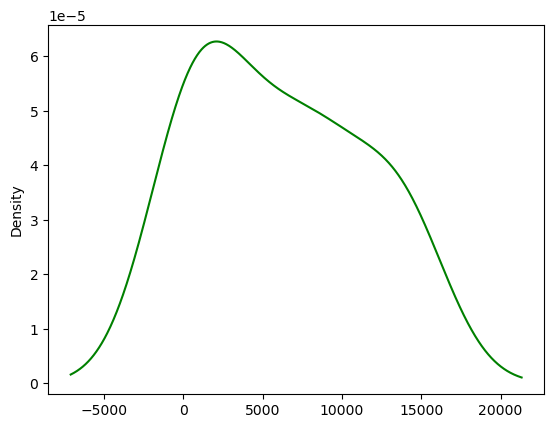

In [5]:
# Visualize the value counts of 
population_group_count.plot.density(color='green')

In [6]:
# Determine which values to replace if counts are less than ...?
## The most straightforward method is to use a density plot to identify where the value counts "fall off" 
## and set the threshold within this region.
replace_population_group = list(population_group_count[population_group_count < 5000].index)


# Replace in dataframe
for app in replace_population_group:
    binaryC_df.population_group_code = binaryC_df.population_group_code.replace(app,"Other")
    
# Check to make sure binning was successful
binaryC_df.population_group_code.value_counts()

Other    16603
1B       14218
5        14145
4        14035
9A       13240
3        11067
6         8865
2         8845
1C        8096
9B        7977
1A        5865
Name: population_group_code, dtype: int64

In [7]:
offense_code_count = binaryC_df.offense_code.value_counts()
offense_code_count

23F    35024
23H    29737
220    21125
240    14899
23D     6767
120     4993
26A     3384
26B     2634
280     1171
270      853
26F      830
250      464
23G      399
23C      309
26E      166
23A       82
23B       75
23E       43
26D        1
Name: offense_code, dtype: int64

<AxesSubplot:ylabel='Density'>

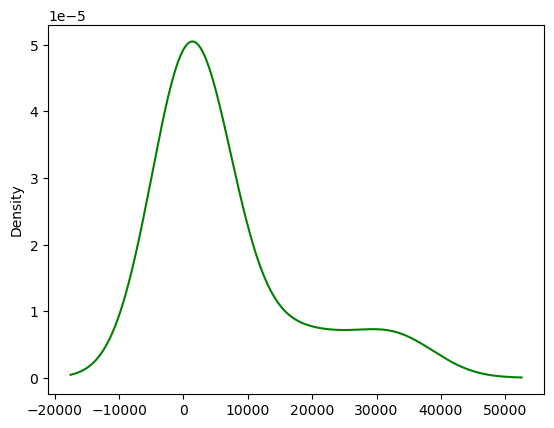

In [8]:
# Visualize the value counts of 
offense_code_count.plot.density(color='green')

In [9]:
# Determine which values to replace if counts are less than ...?
replace_offense = list(offense_code_count[offense_code_count < 14000].index)


# Replace in dataframe
for app in replace_offense:
    binaryC_df.offense_code = binaryC_df.offense_code.replace(app,"Other")
    
# Check to make sure binning was successful
binaryC_df.offense_code.value_counts()

23F      35024
23H      29737
Other    22171
220      21125
240      14899
Name: offense_code, dtype: int64

In [10]:
# Generate our categorical variable lists
binary_cat = binaryC_df.dtypes[binaryC_df.dtypes == "object"].index.tolist()
binary_cat

['population_group_code', 'offense_code', 'victim_type_code']

In [11]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(binaryC_df[binary_cat]))


# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(binary_cat)
print(encode_df.shape)
encode_df.head(10)

(122956, 25)


,population_group_code_1A,population_group_code_1B,population_group_code_1C,population_group_code_2,population_group_code_3,population_group_code_4,population_group_code_5,population_group_code_6,population_group_code_9A,population_group_code_9B,...,offense_code_Other,victim_type_code_B,victim_type_code_F,victim_type_code_G,victim_type_code_I,victim_type_code_L,victim_type_code_O,victim_type_code_R,victim_type_code_S,victim_type_code_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
binaryC_df = binaryC_df.copy()

binaryC_df['recovered_flag'] = le.fit_transform(binaryC_df['recovered_flag'])

In [13]:
# Merge one-hot encoded features and drop the originals
binaryC_df = binaryC_df.merge(encode_df,left_index=True, right_index=True)
binaryC_df = binaryC_df.drop(binary_cat,1)
binaryC_df.head()

C:\Users\tomok\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,offender_age,location_code,prop_desc_code,recovered_flag,population_group_code_1A,population_group_code_1B,population_group_code_1C,population_group_code_2,population_group_code_3,population_group_code_4,...,offense_code_Other,victim_type_code_B,victim_type_code_F,victim_type_code_G,victim_type_code_I,victim_type_code_L,victim_type_code_O,victim_type_code_R,victim_type_code_S,victim_type_code_U
0,0.0,25,20,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20,77,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,20,65,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,20,13,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,20,77,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = binaryC_df.recovered_flag
X = binaryC_df.drop(columns=['recovered_flag'])


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 18
hidden_nodes_layer2 = 10
hidden_nodes_layer3 = 6

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) 

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                522       
                                                                 
 dense_1 (Dense)             (None, 10)                190       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
2882/2882 [==============================] - 7s 2ms/step - loss: 0.3683 - accuracy: 0.8541
Epoch 2/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3447 - accuracy: 0.8620
Epoch 3/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3409 - accuracy: 0.8631
Epoch 4/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3385 - accuracy: 0.8645
Epoch 5/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3371 - accuracy: 0.8651
Epoch 6/100
2882/2882 [==============================] - 5s 2ms/step - loss: 0.3360 - accuracy: 0.8646
Epoch 7/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3349 - accuracy: 0.8657
Epoch 8/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3341 - accuracy: 0.8662
Epoch 9/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3335 - accuracy: 0.8665
Epoch 10/100
2882/2882 [==============================] - 6s 2ms/step - l

2882/2882 [==============================] - 6s 2ms/step - loss: 0.3225 - accuracy: 0.8707
Epoch 80/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3224 - accuracy: 0.8709
Epoch 81/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3223 - accuracy: 0.8714
Epoch 82/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3225 - accuracy: 0.8705
Epoch 83/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3221 - accuracy: 0.8708
Epoch 84/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3220 - accuracy: 0.8712
Epoch 85/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3219 - accuracy: 0.8707
Epoch 86/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3223 - accuracy: 0.8705
Epoch 87/100
2882/2882 [==============================] - 6s 2ms/step - loss: 0.3220 - accuracy: 0.8708
Epoch 88/100
2882/2882 [==============================] - 6s 2ms/step - loss:

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

961/961 - 1s - loss: 0.3313 - accuracy: 0.8658 - 1s/epoch - 1ms/step
Loss: 0.3313010036945343, Accuracy: 0.8658381700515747


### The model's weights are saved every 5 epochs and export your results to an HDF5 file

In [ ]:
# Import checkpoint dependencies
import os 
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:n}.hdf5"

In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 18
hidden_nodes_layer2 = 10

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Restore the model weights
nn_new.load_weights("checkpoints/weights.5.hdf5")

# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Export our model to HDF5 file
nn_new.save("Cargotheft.h5")

In [ ]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model('Cargotheft.h5')

In [ ]:
# Evaluate the completed model using the test data
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")